In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import  StandardScaler, LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

In [29]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

train_ID = train['PassengerId']
test_ID = test['PassengerId']
y_train = train['Survived'].values
train_r = train.shape[0]
test_r = test.shape[0]
data = pd.concat([train, test]).reset_index(drop=True)

c:\program files\python37\lib\site-packages\ipykernel_launcher.py:9: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  if __name__ == '__main__':


In [30]:
#Checking null values
data.isnull().sum().sort_values(ascending=False)

Cabin          1014
Survived        418
Age             263
Embarked          2
Fare              1
Ticket            0
SibSp             0
Sex               0
Pclass            0
PassengerId       0
Parch             0
Name              0
dtype: int64

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

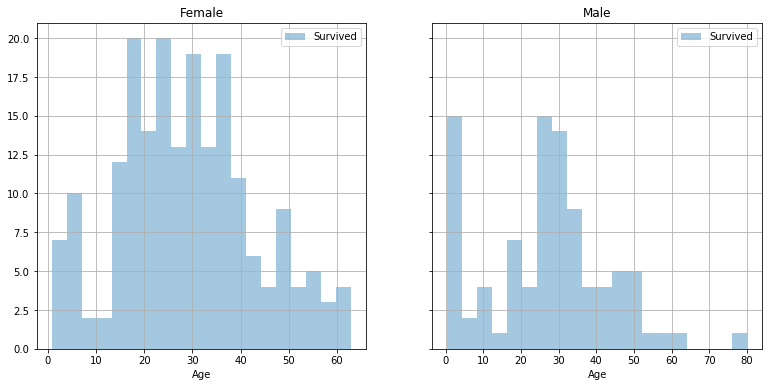

In [32]:
#seaborn distplot to check the survival chances as per age and sex
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(13,6), sharey=True)
female = train[train['Sex'] == 'female']
male = train[train['Sex'] == 'male']
ax = sns.distplot(female[female['Survived']==1].Age.dropna(), label='Survived', ax=axes[0], bins=20, kde=False)
ax.set_title('Female')
ax.legend()
ax.grid()
ax = sns.distplot(male[male['Survived']==1].Age.dropna(), label='Survived', ax=axes[1], bins=20, kde=False)
ax.set_title('Male')
ax.legend()
ax.grid()

##### Conclusion: Good Survival chances- Infants, Females of age 14-40, Males of age 25-35

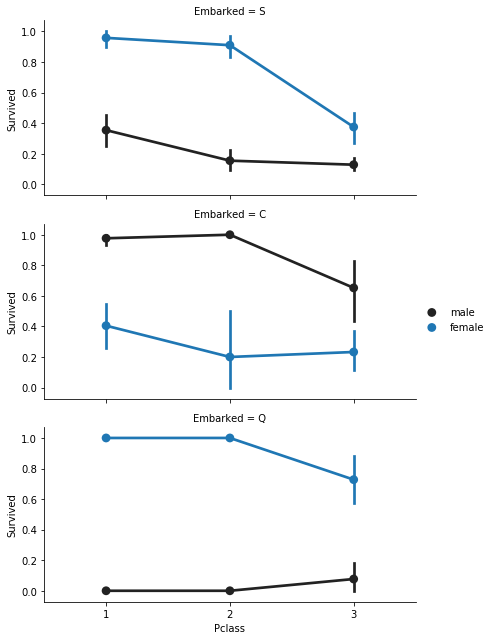

In [33]:
facet = sns.FacetGrid(train, row='Embarked', height=3, aspect=2)
facet.map(sns.pointplot, 'Pclass', 'Survived','Sex',palette=None,  order=None, hue_order=None)
facet.add_legend()

Conclusion:

Good Survival Chances:
                       
                       Embarked `S` Females, Pclass 1 and 2

                       Embarked `C` Males , Pclass 1 and 2
                       
                       Embarked `Q` Females, Pclass 1, 2 and 3
                       
In all cases Males of Passenger class 3 have low survival chances 

In [34]:
data.drop('Survived', axis=1, inplace=True) #Drop target column from dataset. Already saved in y_train variable earlier

In [35]:
data.Cabin = data.Cabin.fillna('U0')

In [36]:
import re
deck = {"A": 1, "B": 2, "C": 3, "D": 4, "E": 5, "F": 6, "G": 7, "U": 8}
data['Deck'] = data['Cabin'].map(lambda x: re.compile("([a-zA-Z]+)").search(x).group()).map(deck)
'''data['Cabin'].map(lambda x: re.compile("([a-zA-Z]+)").search(x).group()) will extract the 1st 
   character/letter of deck e.g. U for U0, C for C123 using regex
   .map(deck) will change that letter to corresponding number from deck dict
'''
data['Deck'] = data['Deck'].fillna(0)
data['Deck'] = data['Deck'].astype(int)

In [37]:
data.drop('Cabin', axis=1, inplace=True)

In [38]:
data['Title'] = data.Name.str.extract('([A-Za-z]+)\.')
data.Title.value_counts()

Mr          757
Miss        260
Mrs         197
Master       61
Rev           8
Dr            8
Col           4
Mlle          2
Ms            2
Major         2
Mme           1
Jonkheer      1
Don           1
Capt          1
Dona          1
Sir           1
Lady          1
Countess      1
Name: Title, dtype: int64

In [39]:
a = data.groupby('Title')
a.count().rsub(a.size(), axis=0)['Age']

Title
Capt          0
Col           0
Countess      0
Don           0
Dona          0
Dr            1
Jonkheer      0
Lady          0
Major         0
Master        8
Miss         50
Mlle          0
Mme           0
Mr          176
Mrs          27
Ms            1
Rev           0
Sir           0
Name: Age, dtype: int64

In [40]:
#Fill missing age values
data.Age = data.Age.fillna(data.groupby(['Title', 'Sex'])['Age'].transform('median'))
bins = [0, 11, 18, 22, 27, 33, 40, 66, 100]
labels = [0, 1, 2, 3, 4, 5, 6, 7]
data.Age = pd.cut(data.Age, bins=bins, labels=labels, right=True)
data.Age = data.Age.astype(int)
data.Age.isna().sum()

0

In [41]:
#filling missing embarked data with most frequent value
data.Embarked = data.Embarked.fillna('S')

In [42]:
#1 missing data in Fare column. Filling with mean fare value
data.Fare = data.Fare.fillna(33.295479)

In [43]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
Age            1309 non-null int32
Embarked       1309 non-null object
Fare           1309 non-null float64
Name           1309 non-null object
Parch          1309 non-null int64
PassengerId    1309 non-null int64
Pclass         1309 non-null int64
Sex            1309 non-null object
SibSp          1309 non-null int64
Ticket         1309 non-null object
Deck           1309 non-null int32
Title          1309 non-null object
dtypes: float64(1), int32(2), int64(4), object(5)
memory usage: 112.6+ KB


In [44]:
data.Age = data.Age.astype(int)

In [45]:
#Converting categorical variable to numeric
gender = {'male':0, 'female':1}
data.Sex = data.Sex.map(gender)

In [46]:
emb = {'S':0, 'C':1, 'Q':2}
data.Embarked = data.Embarked.map(emb)

In [47]:
data.drop(['Name', 'PassengerId', 'SibSp', 'Ticket'], axis=1, inplace=True)
label_encoder = LabelEncoder() 
data['Title']= label_encoder.fit_transform(data['Title']) 


In [48]:
data.Age = data.Age.astype(int)

data['Age'] = StandardScaler().fit_transform(data['Age'].values.reshape(-1, 1))
data['Embarked'] = StandardScaler().fit_transform(data['Embarked'].values.reshape(-1, 1))
data['Fare'] = StandardScaler().fit_transform(data['Fare'].values.reshape(-1, 1))
data['Parch'] = StandardScaler().fit_transform(data['Parch'].values.reshape(-1, 1))
data['Pclass'] = StandardScaler().fit_transform(data['Pclass'].values.reshape(-1, 1))
data['Deck'] = StandardScaler().fit_transform(data['Deck'].values.reshape(-1, 1))
data['Title'] = StandardScaler().fit_transform(data['Title'].values.reshape(-1, 1))


train = data[:train_r]
test = data[train_r:]

In [49]:
svc_par = dict(     
    C = [1.5, 1.6, 1.7, 1.8,2.0],     
    kernel = ['rbf', 'sigmoid', 'linear', 'poly'], 
    gamma=['scale', 'auto'],
    degree = [ i for i in range(1,6)],
    decision_function_shape=['ovr', 'ovo']
)

svc = SVC()
svc_cv = GridSearchCV(estimator=svc, param_grid=svc_par, cv=5) 
svc_cv.fit(train, y_train)
print("Best score: {}".format(svc_cv.best_score_))
print("Optimal params: {}".format(svc_cv.best_estimator_))

svc_pred = svc_cv.predict(test)
svc_cv.score(train, y_train)
acc_svc = round(svc_cv.score(train, y_train) * 100, 2)
print(round(acc_svc,2,), "%")

kaggle = pd.DataFrame({'PassengerId': test_ID, 'Survived': svc_pred})
kaggle.to_csv('gender_submission.csv', index=False)

Best score: 0.8305274971941639
Optimal params: SVC(C=1.8, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=1, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
84.96 %


In [50]:
kaggle = pd.DataFrame({'PassengerId': test_ID, 'Survived': svc_pred})
kaggle.to_csv('gender_submission.csv', index=False)